# Configuration

## Packages to import

In [6]:
def run_from_ipython():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False
from platform import python_version

print(python_version())

3.6.8


In [2]:
if run_from_ipython():
    %load_ext autoreload
    %autoreload 2
    %matplotlib notebook

from insight import *

import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd
import argparse

['main.ipynb', 'LICENSE', 'LoughranMcDonald_MasterDictionary_2018.csv', 'requirements.txt', 'main.py', 'sec-scrapper.py', '__pycache__', 'README.md', 'Load_MasterDictionary.py', 'Filing metrics.py']
/home/alex/Desktop/Insight project/sec-scrapper
 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



### Set the nb of processes to use based on cmd line arguments/setting

In [3]:
if run_from_ipython():
    nb_processes_requested = mp.cpu_count()  # From IPython, fixed setting
    nb_processes_requested = 1 # From IPython, fixed setting
else:
    ap = argparse.ArgumentParser()
    ap.add_argument("-p", "--processes", type=int, default=1, help="Number of processes launched to process the reports.")
    args = vars(ap.parse_args())
    nb_processes_requested = args["processes"]
    if not 1 <= nb_processes_requested <= mp.cpu_count():
        raise ValueError('[ERROR] Number of processes requested is incorrect.\
                         \n{} CPUs are available on this machine, please select a number of processes between 1 and {}'
                         .format(mp.cpu_count()))

## Settings dictionary

In [4]:
home = os.path.expanduser("~")
_s = {
    'path_stage_1_data': os.path.join(home, 'Desktop/filtered_text_data/nd_data/'),
    'path_stock_database': os.path.join(home, 'Desktop/Insight project/Database/Ticker_stock_price.csv'),
    'path_stock_indexes': os.path.join(home, 'Desktop/Insight project/Database/Indexes/'),
    'path_cik_ticker_lookup': os.path.join(home, 'Desktop/Insight project/Database/cik_ticker.csv'),
    'path_master_dictionary': os.path.join(home, 'Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv'),
    'path_dump_crsp': os.path.join(home, 'Desktop/Insight project/Database/dump_crsp_merged.txt'),
    'path_output_folder': os.path.join(home, 'Desktop/Insight project/Outputs'),
    'metrics': ['diff_jaccard', 'diff_cosine_tf', 'diff_cosine_tf_idf', 'diff_minEdit', 'diff_simple', 'sing_LoughranMcDonald'],
    'differentiation_mode': 'monthly',
    'time_range': [(2010, 1), (2012, 4)],
    'bin_count': 5,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [5]:
_s['pf_init_value'] = 1000000
_s['epsilon'] = 0.0001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'monthly':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']

_s['intersection_table'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
_s['straight_table'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}

In [6]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Find all the unique CIK from the SEC filings

In [7]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 306,198 10-X
[INFO] Shrunk to 276,841 ['10-K', '10-Q']


 32%|███▏      | 88678/276841 [00:00<00:00, 886778.73it/s]

[INFO] Found 14,549 unique CIK in master index


100%|██████████| 276841/276841 [00:00<00:00, 870234.26it/s]

[INFO] cik_path contains data on 14,549 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [8]:
lookup = pre_processing.load_lookup(s)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [9]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 8,207 CIK | lookup: 8,207 CIK


### Load stock data and drop all CIKs for which we don't have data

In [10]:
# Load all stock prices
stock_data = pre_processing.load_stock_data(s)

100%|██████████| 30563446/30563446 [00:58<00:00, 521409.61it/s]


In [11]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

4668
[INFO] Intersected lookup & stock data.
lookup: 4,791 tickers | stock_data: 4,668 tickers


### Load stock indexes - will serve as benchmark later on

In [12]:
index_data = pre_processing.load_index_data(s)
print("[INFO] Loaded the following index data:", list(index_data.keys()))

[INFO] Loaded the following index data: ['IXIC', 'SPX', 'DJI', 'RUT']


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [13]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 4,791 CIK | lookup: 4,791 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [14]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [15]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 4791/4791 [00:00<00:00, 7125.44it/s]



[INFO] 1387 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
cik_dict: 3,404 CIK


In [16]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker tabke")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 3,404 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker tabke
- The stock data is available for that ticker
- There is one and only one report per quarter


In [17]:
"""
# [USER SETTINGS]
example = 'apple'  # Debug
# Examples of companies
example_companies = {
    'apple': ['AAPL', 320193],
    'baxter': ['BAX', 10456],
    'facebook': ['FB', 1326801],
    'google': ['GOOGL', 1652044],
    'microsoft': ['MSFT', 789019],
    'amazon': ['AMZN', 1018724],
    'johnson': ['JNJ', 200406],
    'jpmorgan': ['JPM', 19617]
}

# [DEBUG]: isolate a subset of companies
company = 'apple'
cik_path = {
    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],
    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]],
    example_companies['jpmorgan'][1]: cik_path[example_companies['jpmorgan'][1]],
    example_companies['amazon'][1]: cik_path[example_companies['amazon'][1]],
    example_companies['johnson'][1]: cik_path[example_companies['johnson'][1]],
    
}
cik_path.keys()
"""

"\n# [USER SETTINGS]\nexample = 'apple'  # Debug\n# Examples of companies\nexample_companies = {\n    'apple': ['AAPL', 320193],\n    'baxter': ['BAX', 10456],\n    'facebook': ['FB', 1326801],\n    'google': ['GOOGL', 1652044],\n    'microsoft': ['MSFT', 789019],\n    'amazon': ['AMZN', 1018724],\n    'johnson': ['JNJ', 200406],\n    'jpmorgan': ['JPM', 19617]\n}\n\n# [DEBUG]: isolate a subset of companies\ncompany = 'apple'\ncik_path = {\n    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],\n    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]],\n    example_companies['jpmorgan'][1]: cik_path[example_companies['jpmorgan'][1]],\n    example_companies['amazon'][1]: cik_path[example_companies['amazon'][1]],\n    example_companies['johnson'][1]: cik_path[example_companies['johnson'][1]],\n    \n}\ncik_path.keys()\n"

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [18]:
# Processing the reports will be done in parrallel in a random order
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
#debug = [[k, v, {**s}] for k, v in cik_path.items() if k==98338]  # settings are cast to dict for pickling
debug = [[k, v, {**s}] for k, v in cik_path.items()]  # settings are cast to dict for pickling

data_to_process = debug[:100]  # Debug
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
#qtr_metric_result = {key: [] for key in s['list_qtr']}
if nb_processes_requested > 1:
    with mp.Pool(processes=nb_processes_requested) as p:
    #with mp.Pool(processes=min(mp.cpu_count(), 1)) as p:
        print("[INFO] Starting a pool of {} workers".format(nb_processes_requested))

        with tqdm(total=len(data_to_process)) as pbar:
            for i, value in tqdm(enumerate(p.imap_unordered(processing.process_cik, data_to_process))):
                pbar.update()
                #qtr = list_qtr[i]
                # Each quarter gets a few metrics
                if value[1] == {}:
                    # The parsing failed
                    del cik_scores[value[0]]
                else:
                    cik_scores[value[0]] = value[1]
                processing_stats[value[2]] += 1
else:
    print("[INFO] Running on {} core (multiprocessing is off)".format(nb_processes_requested))
    with tqdm(total=len(data_to_process)) as pbar:
        for i, value in tqdm(enumerate(map(processing.process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
        
           
        #qtr_metric_result[value['0']['qtr']] = value
print("[INFO] {} CIK failed to be processed.".format(sum(processing_stats[1:])))
print("Detailed stats and error codes:", processing_stats)

  0%|          | 0/100 [00:00<?, ?it/s]
0it [00:00, ?it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.3860537945783969, 'diff_cosine_tf': 0.801119807207378, 'diff_cosine_tf_idf': 0.7755372337509133, 'diff_minEdit': 0.844539146155044, 'diff_simple': 0.7422182867262703, 'sing_LoughranMcDonald': -0.0016647563700913082, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.849773016926045, 'diff_cosine_tf': 0.991424873394707, 'diff_cosine_tf_idf': 0.9897739952229097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001411784041286702, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.8165114586808954, 'diff_cosine_tf': 0.9931562811226052, 'diff_cosine_tf_idf': 0.9899288855527351, 'diff_minEdit': 0.9067664632595982, 'diff_simple': 0.9

  1%|          | 1/100 [00:02<03:28,  2.11s/it]
1it [00:02,  2.11s/it]

{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0014269945956714484, 'diff_cosine_tf': 0.0786638084494358, 'diff_cosine_tf_idf': 0.047711975611118215, 'diff_minEdit': 0.6664487788555444, 'diff_simple': 0.19672614059412982, 'sing_LoughranMcDonald': -0.00011607148581765074, '0': 

  2%|▏         | 2/100 [00:04<03:40,  2.25s/it]
2it [00:04,  2.25s/it]

{'diff_jaccard': 0.8362952312188306, 'diff_cosine_tf': 0.9648353687672948, 'diff_cosine_tf_idf': 0.9572619713261508, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -8.463122594784699e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.6315610713014862, 'diff_cosine_tf': 0.9528539526605745, 'diff_cosine_tf_idf': 0.942433069958026, 'diff_minEdit': 0.9999189792798313, 'diff_simple': 0.9999773141983528, 'sing_LoughranMcDonald': -0.0001316399355698108, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.020793024098900204, 'diff_cosine_tf': 0.3720756289996961, 'diff_cosine_tf_idf': 0.32053879098052995, 'diff_minEdit': 0.6943824233670123, 'diff_simple': 0.6020676382482334, 'sing_LoughranMcDonald': -0.0001546644065347483, 

  3%|▎         | 3/100 [00:09<04:54,  3.04s/it]
3it [00:09,  3.04s/it]

{'diff_jaccard': 0.7772132281918013, 'diff_cosine_tf': 0.9855955316771894, 'diff_cosine_tf_idf': 0.9839490310254778, 'diff_minEdit': 0.9984419978039588, 'diff_simple': 0.9955129536754014, 'sing_LoughranMcDonald': -9.845351948027576e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8071197604987385, 'diff_cosine_tf': 0.9906833884779943, 'diff_cosine_tf_idf': 0.9886998261698328, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001447403148537185, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.008968268866131298, 'diff_cosine_tf': 0.3363879695576387, 'diff_cosine_tf_idf': 0.2566075545618522, 'diff_minEdit': 0.9404836525457421, 'diff_simple': 0.676108589170253, 'sing_LoughranMcDonald': -0.0006202763891788644, '0'

  4%|▍         | 4/100 [00:12<04:35,  2.87s/it]
4it [00:12,  2.87s/it]

{'diff_jaccard': 0.006799448806233028, 'diff_cosine_tf': 0.28310510490733964, 'diff_cosine_tf_idf': 0.21671498697845026, 'diff_minEdit': 0.9557130133393559, 'diff_simple': 0.62207160810011, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.23276236455665106, 'diff_cosine_tf': 0.5720100602546653, 'diff_cosine_tf_idf': 0.5606708666171527, 'diff_minEdit': 0.7224201606056532, 'diff_simple': 0.6032467853344146, 'sing_LoughranMcDonald': -0.0015815906323559327, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7674770704370789, 'diff_cosine_tf': 0.9807262342971406, 'diff_cosine_tf_idf': 0.9784421144168743, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016215781496927884, '0': {'type': '10-

  5%|▌         | 5/100 [00:13<03:51,  2.44s/it]
5it [00:13,  2.44s/it]

{'diff_jaccard': 0.6510813327488576, 'diff_cosine_tf': 0.9624306228538935, 'diff_cosine_tf_idf': 0.95671373092321, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017594243648834365, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.6390080149847885, 'diff_cosine_tf': 0.9763900790806668, 'diff_cosine_tf_idf': 0.9693749453499055, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010837399024741425, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}


  6%|▌         | 6/100 [00:14<02:55,  1.87s/it]
6it [00:14,  1.87s/it]

[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.6300540749157397, 'diff_cosine_tf': 0.9787998176942219, 'diff_cosine_tf_idf': 0.9692360224146678, 'diff_minEdit': 0.8987704491766189, 'diff_simple': 0.8026429298067143, 'sing_LoughranMcDonald': -0.0009937336547038362, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 30), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.23979162555265054, 'diff_cosine_tf': 0.8489382178576539, 'diff_cosine_tf_idf': 0.8266530459639843, 'diff_minEdit': 0.7963698076921925, 'diff_simple': 0.5912339217105629, 'sing_LoughranMcDonald': -0.0031169712684809936, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7161852412155307, 'diff_cosine_tf': 0.9671925439119831, 'diff_cosine_tf_idf': 0.9571053487380847, 'diff_minEdit':

  7%|▋         | 7/100 [00:15<02:50,  1.83s/it]
7it [00:15,  1.83s/it]

{'diff_jaccard': 0.7477284842347768, 'diff_cosine_tf': 0.9378466987346725, 'diff_cosine_tf_idf': 0.9342055860308777, 'diff_minEdit': 0.9930463086255363, 'diff_simple': 0.9772667781988688, 'sing_LoughranMcDonald': -0.0003643184812325361, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8467006236808937, 'diff_cosine_tf': 0.980182110505539, 'diff_cosine_tf_idf': 0.975131727010176, 'diff_minEdit': 0.9946675908018736, 'diff_simple': 0.9843227169575085, 'sing_LoughranMcDonald': -0.00035413223239211613, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}


  8%|▊         | 8/100 [00:16<02:06,  1.38s/it]
8it [00:16,  1.38s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7940826390670686, 'diff_cosine_tf': 0.9906773244431994, 'diff_cosine_tf_idf': 0.9901337572138124, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004663935107191081, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8134297667949074, 'diff_cosine_tf': 0.9938677316429787, 'diff_cosine_tf_idf': 0.9935633610452812, 'diff_minEdit': 0.9392802556620814, 'diff_simple': 0.9908920383493123, 'sing_LoughranMcDonald': -0.0004679442549336972, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.02813983545478716, 'diff_cosine_tf': 0.40278891626086166, 'diff_cosine_tf_idf': 0.33764900614785087, 'diff_minEdit': 0.5874725896509647, 'diff_sim

  9%|▉         | 9/100 [00:17<02:06,  1.39s/it]
9it [00:17,  1.39s/it]

{'diff_jaccard': 0.0256565057340768, 'diff_cosine_tf': 0.42514172859273763, 'diff_cosine_tf_idf': 0.3619353809318746, 'diff_minEdit': 0.5708061020294447, 'diff_simple': 0.2928342348833728, 'sing_LoughranMcDonald': -0.00021106031368912703, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.026459162255798793, 'diff_cosine_tf': 0.43483605161797684, 'diff_cosine_tf_idf': 0.37235627105737773, 'diff_minEdit': 0.5874571580624396, 'diff_simple': 0.31830699474852475, 'sing_LoughranMcDonald': -0.0007636173811229666, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8019866496881459, 'diff_cosine_tf': 0.9579201422186562, 'diff_cosine_tf_idf': 0.9438773770926842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000681444738739706

 10%|█         | 10/100 [00:19<02:26,  1.62s/it]
10it [00:19,  1.62s/it]

{'diff_jaccard': 0.2625614654356241, 'diff_cosine_tf': 0.6977065362843143, 'diff_cosine_tf_idf': 0.6855979695016776, 'diff_minEdit': 0.8599206163165398, 'diff_simple': 0.6672865684730832, 'sing_LoughranMcDonald': -0.0018942104854523852, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8321030700647282, 'diff_cosine_tf': 0.9875250863814675, 'diff_cosine_tf_idf': 0.9837447396248055, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018140226325141767, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.813280107820436, 'diff_cosine_tf': 0.9895007269954188, 'diff_cosine_tf_idf': 0.9834947731160235, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00168992450231807, '0': {'type': '10-Q', 'published': dat

 11%|█         | 11/100 [00:21<02:18,  1.56s/it]
11it [00:21,  1.56s/it]

This is the res {'_i_1': [(6476, 6498)], '_i_2': [(29598, 29622)], '_i_3': [(64460, 64485)], '_i_4': [(65862, 65884)], 'ii_1': [(67300, 67318)], 'ii_1a': [], 'ii_2': [(67891, 67916)], 'ii_4': [(68040, 68057)], 'ii_5': [(68088, 68110)], 'ii_6': [(68175, 68197)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120504_10-Q_edgar_data_1171486_0001193125-12-210830_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7523783026312917, 'diff_cosine_tf': 0.9892394958084767, 'diff_cosine_tf_idf': 0.9881572007099936, 'diff_minEdit': 0.9645377369206383, 'diff_simple': 0.9869229203447493, 'sing_LoughranMcDonald': -0.000118317579200641, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.9005886241431174, 'diff_cosine_tf': 0.9967040018056017, 'diff_cosine_tf_idf': 0.9963132257872046, 'diff_minEd

 12%|█▏        | 12/100 [00:23<02:30,  1.71s/it]
12it [00:23,  1.71s/it]

{'diff_jaccard': 0.7068157651230558, 'diff_cosine_tf': 0.9884875547654789, 'diff_cosine_tf_idf': 0.9873269655950045, 'diff_minEdit': 0.9629954657766393, 'diff_simple': 0.9862385221407226, 'sing_LoughranMcDonald': -0.0001545374114425234, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
{'diff_jaccard': 0.7319909332516568, 'diff_cosine_tf': 0.9773403131669759, 'diff_cosine_tf_idf': 0.974912779120439, 'diff_minEdit': 0.9279556755153432, 'diff_simple': 0.9724044073222838, 'sing_LoughranMcDonald': -0.0004696877888746722, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0038830225383650503, 'diff_cosine_tf': 0.059254866931442836, 'diff_cosine_tf_idf': 0.03437572186058513, 'diff_minEdit': 0.5500506783459332, 'diff_simple': 0.23413693949923306, 'sing_LoughranMc

 13%|█▎        | 13/100 [00:24<02:07,  1.47s/it]
13it [00:24,  1.47s/it]

{'diff_jaccard': 0.34078715857018643, 'diff_cosine_tf': 0.8484800373486316, 'diff_cosine_tf_idf': 0.8165129231581103, 'diff_minEdit': 0.8197065056088223, 'diff_simple': 0.7259359358202228, 'sing_LoughranMcDonald': -0.0009015942916509738, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.3221825344665213, 'diff_cosine_tf': 0.844181864443793, 'diff_cosine_tf_idf': 0.8081346300676032, 'diff_minEdit': 0.804080829739074, 'diff_simple': 0.7153138342314748, 'sing_LoughranMcDonald': -0.0013495875798270505, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7085330776605945, 'diff_cosine_tf': 0.9590137408308428, 'diff_cosine_tf_idf': 0.9498495082947558, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010935884360732432, '0': 

 14%|█▍        | 14/100 [00:25<01:53,  1.32s/it]
14it [00:24,  1.32s/it]

{'diff_jaccard': 0.7752655549656005, 'diff_cosine_tf': 0.9631921740178377, 'diff_cosine_tf_idf': 0.9477137453206429, 'diff_minEdit': 0.934443399707209, 'diff_simple': 0.9478632214142039, 'sing_LoughranMcDonald': 3.9103957019151706e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.014767453070639657, 'diff_cosine_tf': 0.3409887944121792, 'diff_cosine_tf_idf': 0.2520173320267983, 'diff_minEdit': 0.9596049029211564, 'diff_simple': 0.7498051388893787, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.016645132022109103, 'diff_cosine_tf': 0.36144700588875817, 'diff_cosine_tf_idf': 0.268887825522885, 'diff_minEdit': 0.9597153472742165, 'diff_simple': 0.7505419111448789, 'sing_LoughranMcDonald': -3.8968748153

 15%|█▌        | 15/100 [00:25<01:22,  1.03it/s]
15it [00:25,  1.03it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100319_10-K_edgar_data_1122342_0001122342-10-000005_1.txt failed parsing


 16%|█▌        | 16/100 [00:25<01:13,  1.15it/s]
16it [00:25,  1.15it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.23517945409619, 'diff_cosine_tf': 0.7734093319519603, 'diff_cosine_tf_idf': 0.7445485273900172, 'diff_minEdit': 0.7323647056453834, 'diff_simple': 0.7237098400569543, 'sing_LoughranMcDonald': -0.00043723290628512276, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7739041441409324, 'diff_cosine_tf': 0.9495527217652149, 'diff_cosine_tf_idf': 0.94224186556742, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006447621930020009, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7727945240180986, 'diff_cosine_tf': 0.9706532002701889, 'diff_cosine_tf_idf': 0.9630051060272512, 'diff_minEdit': 0.9918156854865717, 'diff_simple':

 17%|█▋        | 17/100 [00:27<01:37,  1.18s/it]
17it [00:27,  1.18s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.10655371776699496, 'diff_cosine_tf': 0.3205032169320547, 'diff_cosine_tf_idf': 0.236391315801481, 'diff_minEdit': 0.8924179841428098, 'diff_simple': 0.5175281032908151, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.8802521008403362, 'diff_simple': 0.969484479838447, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.9243697478991596, 'diff_simple': 0.97536

 18%|█▊        | 18/100 [00:30<02:27,  1.80s/it]
18it [00:30,  1.80s/it]

{'diff_jaccard': 0.3374352234183491, 'diff_cosine_tf': 0.7588937598148343, 'diff_cosine_tf_idf': 0.7305660288757924, 'diff_minEdit': 0.7559214582037003, 'diff_simple': 0.6529929036505963, 'sing_LoughranMcDonald': -0.0003562472456683352, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.024030516219349672, 'diff_cosine_tf': 0.32615247203025927, 'diff_cosine_tf_idf': 0.2756308402020796, 'diff_minEdit': 0.6191996596816165, 'diff_simple': 0.3390604785996576, 'sing_LoughranMcDonald': -0.028930534254808345, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.08912546433736063, 'diff_cosine_tf': 0.17412033171130137, 'diff_cosine_tf_idf': 0.14332019126364234, 'diff_minEdit': 0.6869237261314486, 'diff_simple': 0.28303143388881324, 'sing_LoughranMcD

 19%|█▉        | 19/100 [00:31<01:57,  1.45s/it]
19it [00:31,  1.45s/it]

{'diff_jaccard': 0.9678918543443745, 'diff_cosine_tf': 0.9979084722883192, 'diff_cosine_tf_idf': 0.9962762866622842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003661353041612954, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.4209660164340713, 'diff_cosine_tf': 0.9341015201003188, 'diff_cosine_tf_idf': 0.9175029508554644, 'diff_minEdit': 0.7640948197497753, 'diff_simple': 0.6932824868073877, 'sing_LoughranMcDonald': -0.0015693721788335524, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.8546979293983199, 'diff_cosine_tf': 0.9758017064028953, 'diff_cosine_tf_idf': 0.9738823649537018, 'diff_minEdit': 0.9911024607257055, 'diff_simple': 0.9865518108678603, 'sing_LoughranMcDonald': -0.0007071341118999433, '0'

 20%|██        | 20/100 [00:33<02:06,  1.58s/it]
20it [00:33,  1.58s/it]

{'diff_jaccard': 0.0034771161229277697, 'diff_cosine_tf': 0.2569698161952818, 'diff_cosine_tf_idf': 0.1975623638581084, 'diff_minEdit': 0.8752956917974286, 'diff_simple': 0.5540882187196171, 'sing_LoughranMcDonald': -0.000494974158906265, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.334174944702113, 'diff_cosine_tf': 0.7925124330430073, 'diff_cosine_tf_idf': 0.7672511892549999, 'diff_minEdit': 0.7595103674126747, 'diff_simple': 0.6869748628704471, 'sing_LoughranMcDonald': -0.0017104110341126047, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.011471043613647711, 'diff_cosine_tf': 0.41142684896596177, 'diff_cosine_tf_idf': 0.31760891804889074, 'diff_minEdit': 0.9262020289442098, 'diff_simple': 0.7919865981863855, 'sing_LoughranMcD

 21%|██        | 21/100 [00:33<01:32,  1.18s/it]
21it [00:33,  1.17s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.008288806156516325, 'diff_cosine_tf': 0.06535922345460415, 'diff_cosine_tf_idf': 0.03896029027958956, 'diff_minEdit': 0.5844421172251417, 'diff_simple': 0.21523284369537116, 'sing_LoughranMcDonald': -0.0008297217136353489, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.25321323859574263, 'diff_cosine_tf': 0.31795043687242863, 'diff_cosine_tf_idf': 0.2920879421687883, 'diff_minEdit': 0.6954346729443417, 'diff_simple': 0.4205040746147495, 'sing_LoughranMcDonald': -0.008635487566136368, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.6593857659898352, 'diff_cosine_tf': 0.7971748063943194, 'diff_cosine_tf_idf': 0.7537184824568111, 'diff_minEd

 22%|██▏       | 22/100 [00:34<01:19,  1.02s/it]
22it [00:34,  1.02s/it]

This is the res {'_i_1': [(180315, 180349)], '_i_2': [], '_i_3': [(268887, 268924)], '_i_4': [(269201, 269234)], 'ii_1': [(271279, 271309)], 'ii_1a': [(271529, 271559)], 'ii_6': [(271776, 271809)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_49196_0000950123-10-046488_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.15294461561556844, 'diff_cosine_tf': 0.7467813466948373, 'diff_cosine_tf_idf': 0.7162636490666479, 'diff_minEdit': 0.7227132183426309, 'diff_simple': 0.42031957252375246, 'sing_LoughranMcDonald': -7.591477691582562e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.684979157934687, 'diff_cosine_tf': 0.9737272097428952, 'diff_cosine_tf_idf': 0.9662056273153494, 'diff_minEdit': 0.5159890270322881, 'diff_simple': 0.6108203121644419, 'sin

 23%|██▎       | 23/100 [00:36<01:43,  1.35s/it]
23it [00:36,  1.35s/it]

{'diff_jaccard': 0.7117141906691301, 'diff_cosine_tf': 0.9622693471151943, 'diff_cosine_tf_idf': 0.93220812085105, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0022884476599558745, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.28998287006262363, 'diff_cosine_tf': 0.9021116818994437, 'diff_cosine_tf_idf': 0.8901849675226916, 'diff_minEdit': 0.831586014969344, 'diff_simple': 0.8191522588191834, 'sing_LoughranMcDonald': -0.0008155536774299935, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7310563793970319, 'diff_cosine_tf': 0.9365053676291505, 'diff_cosine_tf_idf': 0.9141630020905861, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005133718065923828, '0': {'type': '10-Q', 'published': 

 24%|██▍       | 24/100 [00:38<02:06,  1.67s/it]
24it [00:38,  1.67s/it]

{'diff_jaccard': 0.7242245494232862, 'diff_cosine_tf': 0.9691208138605408, 'diff_cosine_tf_idf': 0.9635587200784772, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002570223768305236, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}


 25%|██▌       | 25/100 [00:39<01:40,  1.34s/it]
25it [00:39,  1.34s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO]

 26%|██▌       | 26/100 [00:40<01:28,  1.19s/it]
26it [00:40,  1.19s/it]

This is the res {'_i_1': [(5550, 5575)], '_i_2': [(50177, 50198)], '_i_3': [(95772, 95795)], '_i_4': [(98295, 98314)], 'ii_1': [(103386, 103402)], 'ii_1a': [(103633, 103649)], 'ii_2': [], 'ii_3': [(5315, 5335)], 'ii_6': [(5461, 5481), (108852, 108871)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101105_10-Q_edgar_data_1441849_0001104659-10-056176_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.4680554741930605, 'diff_cosine_tf': 0.9519991132225242, 'diff_cosine_tf_idf': 0.9475658751756671, 'diff_minEdit': 0.9887930283280514, 'diff_simple': 0.9690631700271425, 'sing_LoughranMcDonald': -0.0007993716804339325, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.743069873208043, 'diff_cosine_tf': 0.9752086421113071, 'diff_cosine_tf_idf': 0.9705609232280703, 'diff_minEdit': 0.7

 27%|██▋       | 27/100 [00:42<01:49,  1.50s/it]
27it [00:42,  1.50s/it]

{'diff_jaccard': 0.4933273485015761, 'diff_cosine_tf': 0.9531039559917055, 'diff_cosine_tf_idf': 0.9430097635202823, 'diff_minEdit': 0.7688638152983709, 'diff_simple': 0.8299775038030202, 'sing_LoughranMcDonald': -0.00020793994517815948, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.47871948719308094, 'diff_cosine_tf': 0.9537544380867004, 'diff_cosine_tf_idf': 0.9453960186834537, 'diff_minEdit': 0.7695850228980994, 'diff_simple': 0.8286544537434, 'sing_LoughranMcDonald': -0.0005320454992959022, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6917135022762823, 'diff_cosine_tf': 0.9834495473562099, 'diff_cosine_tf_idf': 0.9798131378825795, 'diff_minEdit': 0.7021010609317577, 'diff_simple': 0.8464165469692617, 'sing_LoughranMcDonald':

 28%|██▊       | 28/100 [00:43<01:35,  1.33s/it]
28it [00:43,  1.33s/it]

{'diff_jaccard': 0.33644155802096737, 'diff_cosine_tf': 0.6405237934065333, 'diff_cosine_tf_idf': 0.5895605313391445, 'diff_minEdit': 0.7206537791967768, 'diff_simple': 0.5020440077900183, 'sing_LoughranMcDonald': -0.0007689070575220345, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8837204091969086, 'diff_cosine_tf': 0.9653873253550284, 'diff_cosine_tf_idf': 0.9589791007108955, 'diff_minEdit': 0.9934380260611112, 'diff_simple': 0.973172792031772, 'sing_LoughranMcDonald': -0.0001646681674048225, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.846434400921266, 'diff_cosine_tf': 0.9828314101237053, 'diff_cosine_tf_idf': 0.9807569033477376, 'diff_minEdit': 0.996129926718162, 'diff_simple': 0.9770117647058824, 'sing_LoughranMcDonald': -

 29%|██▉       | 29/100 [00:44<01:25,  1.21s/it]
29it [00:44,  1.21s/it]

{'diff_jaccard': 0.6295672438657208, 'diff_cosine_tf': 0.9479494869841056, 'diff_cosine_tf_idf': 0.9185765677664236, 'diff_minEdit': 0.9912542182227221, 'diff_simple': 0.9901122776319626, 'sing_LoughranMcDonald': -0.0036894515384046354, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.43220670362045754, 'diff_cosine_tf': 0.8224287913466541, 'diff_cosine_tf_idf': 0.7807121557864434, 'diff_minEdit': 0.8364526064526064, 'diff_simple': 0.8274328205128205, 'sing_LoughranMcDonald': -0.002674981421515741, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.361524330198716, 'diff_cosine_tf': 0.7946945929639104, 'diff_cosine_tf_idf': 0.7487954172117114, 'diff_minEdit': 0.8066798213081187, 'diff_simple': 0.8147494004796163, 'sing_LoughranMcDonald

 30%|███       | 30/100 [00:44<01:05,  1.07it/s]
30it [00:44,  1.07it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100303_10-K_edgar_data_892986_0001047469-10-001756_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0043791067041527776, 'diff_cosine_tf': 0.27462396236624886, 'diff_cosine_tf_idf': 0.207296854753463, 'diff_minEdit': 0.9032823550120629, 'diff_simple': 0.5530404364765593, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_s

 31%|███       | 31/100 [00:46<01:21,  1.19s/it]
31it [00:46,  1.19s/it]

{'diff_jaccard': 0.011893621930395448, 'diff_cosine_tf': 0.4468925428318583, 'diff_cosine_tf_idf': 0.3512250578388602, 'diff_minEdit': 0.9171587443766384, 'diff_simple': 0.7871803969879212, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9794300144300144, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.002649010577008467, 'diff_cosine_tf': 0.03121927299213756, 'diff_cosine_tf_idf': 0.019264096989799334, 'diff_minEdit': 0.8764634912107812, 'diff_simple': 0.1915024981047754, 'sing_LoughranMcDonald': -0.001173166994654374, '0': {

 32%|███▏      | 32/100 [00:48<01:34,  1.39s/it]
32it [00:48,  1.39s/it]

{'diff_jaccard': 0.22411116779365703, 'diff_cosine_tf': 0.6957227610224817, 'diff_cosine_tf_idf': 0.6519763435832154, 'diff_minEdit': 0.708920617883415, 'diff_simple': 0.6172369757291568, 'sing_LoughranMcDonald': -0.0001049548465574619, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7011182766462905, 'diff_cosine_tf': 0.9775592839009768, 'diff_cosine_tf_idf': 0.9702969261104415, 'diff_minEdit': 0.9398379473328831, 'diff_simple': 0.9915773126266036, 'sing_LoughranMcDonald': 1.1179026873085763e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.6444791462075338, 'diff_cosine_tf': 0.9830592165953903, 'diff_cosine_tf_idf': 0.9744019288808391, 'diff_minEdit': 0.9380610412926391, 'diff_simple': 0.9913285457809695, 'sing_LoughranMcDonald':

 33%|███▎      | 33/100 [00:48<01:09,  1.04s/it]
33it [00:48,  1.04s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_712770_0001144204-10-025286_1.txt failed parsing


 34%|███▍      | 34/100 [00:49<00:58,  1.14it/s]
34it [00:49,  1.14it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101109_10-Q_edgar_data_712771_0001144204-10-058480_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.48543993529240137, 'diff_cosine_tf': 0.9141033564828126, 'diff_cosine_tf_idf': 0.9054073749627015, 'diff_minEdit': 0.7349373502369162, 'diff_simple': 0.707592196395547, 'sing_LoughranMcDonald': -0.0017315128241753787, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.8067538662877853, 'diff_cosine_tf': 0.9449180295339331, 'diff_cosine_tf_idf': 0.9233701671126042, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001409161388252

 35%|███▌      | 35/100 [00:51<01:19,  1.22s/it]
35it [00:51,  1.22s/it]

{'diff_jaccard': 0.4654586544204789, 'diff_cosine_tf': 0.9063690514894994, 'diff_cosine_tf_idf': 0.8889802339412153, 'diff_minEdit': 0.7755136352661263, 'diff_simple': 0.6854487993762539, 'sing_LoughranMcDonald': -0.0003198885390680838, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.4565858512364021, 'diff_cosine_tf': 0.9189156832794303, 'diff_cosine_tf_idf': 0.9097048045850092, 'diff_minEdit': 0.7792264487872108, 'diff_simple': 0.6797436714391549, 'sing_LoughranMcDonald': -0.0008266425773617923, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8816733802938679, 'diff_cosine_tf': 0.9517821571048247, 'diff_cosine_tf_idf': 0.9370412317454051, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007160551852574311, '0'

 36%|███▌      | 36/100 [00:52<01:27,  1.36s/it]
36it [00:52,  1.36s/it]

{'diff_jaccard': 0.7020318032598897, 'diff_cosine_tf': 0.9821070375926538, 'diff_cosine_tf_idf': 0.9768497752755795, 'diff_minEdit': 0.8598962595111124, 'diff_simple': 0.8656587003752716, 'sing_LoughranMcDonald': -0.0003179258778169536, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7714999362063935, 'diff_cosine_tf': 0.9864147316309132, 'diff_cosine_tf_idf': 0.9779376910507104, 'diff_minEdit': 0.8891852530303406, 'diff_simple': 0.8423228210015596, 'sing_LoughranMcDonald': -0.00025059653875859634, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 23), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.7169452901606637, 'diff_cosine_tf': 0.9867735929048583, 'diff_cosine_tf_idf': 0.9851167088358186, 'diff_minEdit': 0.8315191886823778, 'diff_simple': 0.43440888658367915, 'sing_LoughranMcDon

 37%|███▋      | 37/100 [00:55<01:54,  1.82s/it]
37it [00:55,  1.82s/it]

{'diff_jaccard': 0.8831749258226443, 'diff_cosine_tf': 0.9842585559815853, 'diff_cosine_tf_idf': 0.982896970744958, 'diff_minEdit': 0.9965215821878755, 'diff_simple': 0.9894362034194317, 'sing_LoughranMcDonald': -0.0006967102045376446, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.9101946701902061, 'diff_cosine_tf': 0.9926811031605771, 'diff_cosine_tf_idf': 0.9915705014684835, 'diff_minEdit': 0.9964079770110528, 'diff_simple': 0.9941809227579057, 'sing_LoughranMcDonald': -0.0011558254074413828, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.8797623262578469, 'diff_cosine_tf': 0.9950075354302682, 'diff_cosine_tf_idf': 0.9939665202378506, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011938401299109867, '0':

 38%|███▊      | 38/100 [00:56<01:41,  1.63s/it]
38it [00:56,  1.63s/it]

{'diff_jaccard': 0.7025302956526912, 'diff_cosine_tf': 0.9776737224781314, 'diff_cosine_tf_idf': 0.9743095303938283, 'diff_minEdit': 0.8870340419799044, 'diff_simple': 0.8861438685618549, 'sing_LoughranMcDonald': -0.00025307245872270844, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.7125388735955437, 'diff_cosine_tf': 0.977928156405295, 'diff_cosine_tf_idf': 0.9748926090140362, 'diff_minEdit': 0.8901351442524663, 'diff_simple': 0.9088929389374537, 'sing_LoughranMcDonald': -0.000388460313019078, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.005723147749476034, 'diff_cosine_tf': 0.18836457979585253, 'diff_cosine_tf_idf': 0.14352046657994497, 'diff_minEdit': 0.9458249022592293, 'diff_simple': 0.3984639486537542, 'sing_LoughranMcDon

 39%|███▉      | 39/100 [01:00<02:19,  2.28s/it]
39it [01:00,  2.28s/it]

{'diff_jaccard': 0.28720054975225673, 'diff_cosine_tf': 0.8587379962703425, 'diff_cosine_tf_idf': 0.8439753580798489, 'diff_minEdit': 0.7826830967321322, 'diff_simple': 0.6850232187648296, 'sing_LoughranMcDonald': -0.0014162734395462616, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6671528623121534, 'diff_cosine_tf': 0.9406634788038977, 'diff_cosine_tf_idf': 0.916269855062047, 'diff_minEdit': 0.9907530647125848, 'diff_simple': 0.9906007622490276, 'sing_LoughranMcDonald': -0.0009636298290448952, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7177129621692407, 'diff_cosine_tf': 0.9677908990547021, 'diff_cosine_tf_idf': 0.9533408866008054, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000989557557638322, '0': {

 40%|████      | 40/100 [01:00<01:42,  1.70s/it]
40it [01:00,  1.70s/it]

This is the res {'_i_1': [(3882, 3900)], '_i_2': [(48090, 48109)], '_i_3': [(87597, 87618)], '_i_4': [(93398, 93415)], 'ii_1a': [], 'ii_6': [(96091, 96108)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100511_10-Q_edgar_data_1114200_0000950123-10-047843_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7505976575168207, 'diff_cosine_tf': 0.9894915261332227, 'diff_cosine_tf_idf': 0.9882604522715904, 'diff_minEdit': 0.7824883331208645, 'diff_simple': 0.5944477683211146, 'sing_LoughranMcDonald': -0.00039412389943585974, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.8697832654234912, 'diff_cosine_tf': 0.9958885481891298, 'diff_cosine_tf_idf': 0.9953170621878065, 'diff_minEdit': 0.9994113403206115, 'diff_simple': 0.9991994228360316, 'sing_LoughranMcDonald': -0.0003774290969

 41%|████      | 41/100 [01:06<02:43,  2.77s/it]
41it [01:06,  2.77s/it]

{'diff_jaccard': 0.8802200464127328, 'diff_cosine_tf': 0.9964732654345451, 'diff_cosine_tf_idf': 0.9958892089338371, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030420355077023006, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8468371462662565, 'diff_cosine_tf': 0.9955613587512124, 'diff_cosine_tf_idf': 0.9944574766328204, 'diff_minEdit': 0.9409379766545628, 'diff_simple': 0.9880247355387279, 'sing_LoughranMcDonald': -0.0002591881145138981, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.8448730208413127, 'diff_cosine_tf': 0.9883036622629892, 'diff_cosine_tf_idf': 0.9840592128231365, 'diff_minEdit': 0.9999126179657462, 'diff_simple': 0.9999631695558103, 'sing_LoughranMcDonald': -0.0019506740369274965, '0'

 42%|████▏     | 42/100 [01:07<02:13,  2.31s/it]
42it [01:07,  2.31s/it]

{'diff_jaccard': 0.8918363935759631, 'diff_cosine_tf': 0.987038073144308, 'diff_cosine_tf_idf': 0.9812431659153846, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0021911369799878268, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.9130768280116917, 'diff_cosine_tf': 0.9937204682513198, 'diff_cosine_tf_idf': 0.9920174527274177, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00215185407547083, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8120598552571887, 'diff_cosine_tf': 0.9877864502367878, 'diff_cosine_tf_idf': 0.9844041931402837, 'diff_minEdit': 0.8872048009275247, 'diff_simple': 0.9477940447236062, 'sing_LoughranMcDonald': -0.0003699962858103285, '0': {'type': '10-Q', 'published': 

 43%|████▎     | 43/100 [01:11<02:36,  2.75s/it]
43it [01:11,  2.75s/it]

{'diff_jaccard': 0.917958734908008, 'diff_cosine_tf': 0.998211814315011, 'diff_cosine_tf_idf': 0.9977562162252966, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038352156124355055, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.9659442577573719, 'diff_cosine_tf': 0.9993315514619975, 'diff_cosine_tf_idf': 0.9989997357558866, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003700758444647485, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}


 44%|████▍     | 44/100 [01:13<02:19,  2.49s/it]
44it [01:13,  2.49s/it]

This is the res {'1': [(231317, 231336)], '1a': [], '1b': [(121705, 121725)], '2': [(121750, 121769), (231342, 231363)], '3': [(5377, 5396), (204218, 204232)], '5': [(5509, 5529), (208048, 208063)], '6': [(5652, 5674), (230680, 230697)], '7': [(5706, 5730), (231074, 231095), (231469, 231488)], '7a': [(5827, 5854), (261627, 261649)], '8': [(5918, 5941), (36499, 36518), (261714, 261732)], '9': [(5992, 6013), (261987, 262003)], '9a': [(6111, 6134)], '9b': [(6166, 6186), (267075, 267090)], '10': [(6244, 6268), (267122, 267141)], '11': [(6330, 6354), (267722, 267741)], '12': [(6384, 6407), (267885, 267903)], '13': [(6510, 6532), (268116, 268133)], '14': [(6619, 6643), (268330, 268349)], '15': [(6719, 6742), (268519, 268537)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120309_10-K_edgar_data_1319009_0001144204-12-014022_1.txt failed parsing


 45%|████▌     | 45/100 [01:13<01:48,  1.98s/it]
45it [01:13,  1.98s/it]

This is the res {'_i_3': [(68383, 68404)], '_i_4': [(72560, 72577)], 'ii_1a': [(75328, 75342)], 'ii_5': [], 'ii_6': [(153877, 153894)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100722_10-Q_edgar_data_901219_0000950123-10-067270_1.txt failed parsing


 46%|████▌     | 46/100 [01:14<01:18,  1.45s/it]
46it [01:14,  1.45s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100430_10-Q_edgar_data_82020_0000950123-10-041427_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0026016434587383197, 'diff_cosine_tf': 0.22172105713812315, 'diff_cosine_tf_idf': 0.16812103239235135, 'diff_minEdit': 0.9256257202540379, 'diff_simple': 0.5361947274476814, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333334, 'diff_simple': 0.9628682880427066, 'sing_LoughranMcDonald': 0.0,

 47%|████▋     | 47/100 [01:17<01:41,  1.92s/it]
47it [01:17,  1.92s/it]

{'diff_jaccard': 0.002120097009162838, 'diff_cosine_tf': 0.18057813461414476, 'diff_cosine_tf_idf': 0.13269779876261337, 'diff_minEdit': 0.947574289828446, 'diff_simple': 0.47572212933438107, 'sing_LoughranMcDonald': -0.00015295200828954316, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.002176985717078012, 'diff_cosine_tf': 0.1813072003496099, 'diff_cosine_tf_idf': 0.13733191846032944, 'diff_minEdit': 0.9469756537507854, 'diff_simple': 0.47619936368999866, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9628682880427066, 'sing_LoughranMcDonald': 0.0, '0'

 48%|████▊     | 48/100 [01:17<01:15,  1.44s/it]
48it [01:17,  1.44s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100506_10-Q_edgar_data_1089638_0001144204-10-025007_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.30816012323115144, 'diff_cosine_tf': 0.8390986144102681, 'diff_cosine_tf_idf': 0.8237038418109747, 'diff_minEdit': 0.833929107848793, 'diff_simple': 0.7238684835368646, 'sing_LoughranMcDonald': -0.0009077899626382366, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7045384411104435, 'diff_cosine_tf': 0.962138634041093, 'diff_cosine_tf_idf': 0.9531170059865439, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007444799439493

 49%|████▉     | 49/100 [01:19<01:17,  1.52s/it]
49it [01:19,  1.52s/it]

{'diff_jaccard': 0.008309632105914367, 'diff_cosine_tf': 0.3869083765296808, 'diff_cosine_tf_idf': 0.29325268581629516, 'diff_minEdit': 0.9576218579570689, 'diff_simple': 0.816564131476702, 'sing_LoughranMcDonald': -0.0006238228314334861, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6253488575235063, 'diff_cosine_tf': 0.9620897888209636, 'diff_cosine_tf_idf': 0.9481627828207363, 'diff_minEdit': 0.9355677265652004, 'diff_simple': 0.9876029611051084, 'sing_LoughranMcDonald': -0.0011551328992372874, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.6988174811185558, 'diff_cosine_tf': 0.9826335844546861, 'diff_cosine_tf_idf': 0.9809456632974182, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000993673631724048, '0':

 50%|█████     | 50/100 [01:21<01:34,  1.89s/it]
50it [01:21,  1.89s/it]

{'diff_jaccard': 0.003285949565579749, 'diff_cosine_tf': 0.37076896080248894, 'diff_cosine_tf_idf': 0.27253785468024405, 'diff_minEdit': 0.9582633099829726, 'diff_simple': 0.8371809473243979, 'sing_LoughranMcDonald': -0.00033406372007843633, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.10906326970400265, 'diff_cosine_tf': 0.8365085151801028, 'diff_cosine_tf_idf': 0.7996853628068438, 'diff_minEdit': 0.7711904498089094, 'diff_simple': 0.8336679745967591, 'sing_LoughranMcDonald': -0.01012278151003907, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.9779851464820579, 'diff_cosine_tf': 0.99786147371457, 'diff_cosine_tf_idf': 0.9960638569179577, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.010910696993576129, '0'

 51%|█████     | 51/100 [01:22<01:08,  1.40s/it]
51it [01:22,  1.40s/it]

This is the res {'1a': [(145018, 145034)], '5': [], '6': [(143905, 143922), (145243, 145261)], '7': [(88086, 88106), (144263, 144284)], '8': [(144364, 144384), (145277, 145297)], '9': [(197804, 197820)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100325_10-K_edgar_data_1114220_0001144204-10-015670_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.06398503251880726, 'diff_cosine_tf': 0.3044631337744003, 'diff_cosine_tf_idf': 0.2540960020734357, 'diff_minEdit': 0.6494456372710159, 'diff_simple': 0.3777771455788268, 'sing_LoughranMcDonald': -0.012121468935078015, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.8442273007059766, 'diff_cosine_tf': 0.9380556526998518, 'diff_cosine_tf_idf': 0.9228974028515451, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0

 52%|█████▏    | 52/100 [01:24<01:15,  1.57s/it]
52it [01:24,  1.57s/it]

{'diff_jaccard': 0.007634585145910404, 'diff_cosine_tf': 0.35061841146413536, 'diff_cosine_tf_idf': 0.256909571056068, 'diff_minEdit': 0.8766568273427556, 'diff_simple': 0.8059622196039179, 'sing_LoughranMcDonald': -0.0013345298102310373, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.420770680830274, 'diff_cosine_tf': 0.9529702464085145, 'diff_cosine_tf_idf': 0.9477353726121619, 'diff_minEdit': 0.8053262994208648, 'diff_simple': 0.7516783293004599, 'sing_LoughranMcDonald': -0.0017219047976185368, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7708079011703424, 'diff_cosine_tf': 0.9892013670357936, 'diff_cosine_tf_idf': 0.987041216808049, 'diff_minEdit': 0.9187553728081532, 'diff_simple': 0.9848343362575219, 'sing_LoughranMcDonald'

 53%|█████▎    | 53/100 [01:28<01:49,  2.34s/it]
53it [01:28,  2.34s/it]

{'diff_jaccard': 0.8439126358798988, 'diff_cosine_tf': 0.9910568094499244, 'diff_cosine_tf_idf': 0.9876782357925492, 'diff_minEdit': 0.9962508950709305, 'diff_simple': 0.9907976515377382, 'sing_LoughranMcDonald': -0.0002772817071145251, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0037078393244757376, 'diff_cosine_tf': 0.2458344774208755, 'diff_cosine_tf_idf': 0.1858157410929983, 'diff_minEdit': 0.7926854715365867, 'diff_simple': 0.5857118102400838, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.6318414918414919, 'diff_cosine_tf': 0.7692307692307692, 'diff_cosine_tf_idf': 0.7003763297470764, 'diff_minEdit': 0.8307692307692307, 'diff_simple': 0.8818567805241057, 'sing_LoughranMcDonald': 0.0, '0': {'t

 54%|█████▍    | 54/100 [01:30<01:43,  2.25s/it]
54it [01:30,  2.25s/it]

{'diff_jaccard': 0.3305971671008746, 'diff_cosine_tf': 0.7543835547768248, 'diff_cosine_tf_idf': 0.7301731018882325, 'diff_minEdit': 0.7285890225463723, 'diff_simple': 0.7051539980856848, 'sing_LoughranMcDonald': -0.0002343196616799434, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.2996065509086658, 'diff_cosine_tf': 0.7486231522918542, 'diff_cosine_tf_idf': 0.7229351514616589, 'diff_minEdit': 0.731690993061643, 'diff_simple': 0.6856128323611849, 'sing_LoughranMcDonald': -0.0009137393496487849, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8496317370249554, 'diff_cosine_tf': 0.964691404433665, 'diff_cosine_tf_idf': 0.9626626390257601, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007439347008944506, '0': {'

 55%|█████▌    | 55/100 [01:30<01:16,  1.69s/it]
55it [01:30,  1.69s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.4274519153112795, 'diff_cosine_tf': 0.8207910203093732, 'diff_cosine_tf_idf': 0.794254161916549, 'diff_minEdit': 0.8154817806089045, 'diff_simple': 0.8051396128261847, 'sing_LoughranMcDonald': -0.00022369339510798554, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 19), 'qtr': (2010, 2)}}


 56%|█████▌    | 56/100 [01:30<00:54,  1.23s/it]
56it [01:30,  1.23s/it]

This is the res {'1': [(10401, 10422)], '4': [(23836, 23860)], '6': [(25607, 25629)], '7a': [(47395, 47418)], '10': [], '12': [(7429, 7488)], '14': [(7741, 7790)], '15': [(7862, 7898)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100224_10-K_edgar_data_1024126_0001354488-10-000553_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7856560919863335, 'diff_cosine_tf': 0.9778712998377878, 'diff_cosine_tf_idf': 0.9749328237405613, 'diff_minEdit': 0.9947287312967145, 'diff_simple': 0.9946167250250695, 'sing_LoughranMcDonald': -0.0004108543651868478, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.9142572046388925, 'diff_cosine_tf': 0.9903677217370884, 'diff_cosine_tf_idf': 0.9885772865817406, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranM

 57%|█████▋    | 57/100 [01:34<01:25,  2.00s/it]
57it [01:34,  2.00s/it]

{'diff_jaccard': 0.002743059221421255, 'diff_cosine_tf': 0.11219398585805192, 'diff_cosine_tf_idf': 0.08730637625052924, 'diff_minEdit': 0.9418554396875354, 'diff_simple': 0.32110949390663507, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}


 58%|█████▊    | 58/100 [01:34<01:03,  1.50s/it]
58it [01:34,  1.50s/it]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_1065087_0001144204-10-025377_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.28610501128326743, 'diff_cosine_tf': 0.9269741906916551, 'diff_cosine_tf_idf': 0.918688378208017, 'diff_minEdit': 0.8885567593983507, 'diff_simple': 0.8754147997216285, 'sing_LoughranMcDonald': -0.0006224880963143146, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.008830452583355217, 'diff_cosine_tf': 0.3677851544567561, 'diff_cosine_tf_idf': 0.279593960410102, 'diff_minEdit': 0.9588364848792004, 'diff_simple': 0.7682730854727348, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccar

 59%|█████▉    | 59/100 [01:37<01:18,  1.91s/it]
59it [01:37,  1.91s/it]

{'diff_jaccard': 0.25399462956461055, 'diff_cosine_tf': 0.8607150237554032, 'diff_cosine_tf_idf': 0.8512687275427189, 'diff_minEdit': 0.7792019178169208, 'diff_simple': 0.7924555549666393, 'sing_LoughranMcDonald': -0.0008425406836664337, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8343550601229283, 'diff_cosine_tf': 0.9714080366954537, 'diff_cosine_tf_idf': 0.9585553951978041, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007758844108894172, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8168373035216403, 'diff_cosine_tf': 0.9853000338516159, 'diff_cosine_tf_idf': 0.9784961946526151, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007644430046929398, '0': {'type': '10-Q', 'published':

 60%|██████    | 60/100 [01:39<01:08,  1.71s/it]
60it [01:39,  1.71s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110429_10-Q_edgar_data_1065088_0001065088-11-000006_1.txt failed parsing


 61%|██████    | 61/100 [01:39<00:51,  1.33s/it]
61it [01:39,  1.33s/it]

This is the res {'1': [(8666, 8683)], '1a': [(20219, 20234)], '1b': [(59323, 59344)], '3': [(296181, 296197)], '4': [], '5': [(73655, 73670)], '6': [(79539, 79556)], '7': [(80663, 80682)], '7a': [(315954, 315976)], '8': [(325021, 325039)], '9': [(501806, 501822)], '9b': [(504864, 504879)], '10': [(504953, 504972)], '11': [(505543, 505562)], '12': [(505950, 505968)], '13': [(506396, 506413)], '14': [(506777, 506796)], '15': [(507179, 507197)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100312_10-K_edgar_data_1056903_0001104659-10-014038_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.51259867499046, 'diff_cosine_tf': 0.9546364886873007, 'diff_cosine_tf_idf': 0.9489665206409503, 'diff_minEdit': 0.8800602601044072, 'diff_simple': 0.8818183072359799, 'sing_LoughranMcDonald': -0.0007914036488130052, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing cur

 62%|██████▏   | 62/100 [01:43<01:17,  2.04s/it]
62it [01:43,  2.04s/it]

{'diff_jaccard': 0.4331614989404035, 'diff_cosine_tf': 0.959463339020125, 'diff_cosine_tf_idf': 0.9544721553690407, 'diff_minEdit': 0.8539333343846758, 'diff_simple': 0.799964280645314, 'sing_LoughranMcDonald': -0.00020826636342205607, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.4451732845585403, 'diff_cosine_tf': 0.9469324467027195, 'diff_cosine_tf_idf': 0.9415111132533983, 'diff_minEdit': 0.8330601947869533, 'diff_simple': 0.7738155273493085, 'sing_LoughranMcDonald': -0.00039966421295047614, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6840008689747853, 'diff_cosine_tf': 0.9697284083101441, 'diff_cosine_tf_idf': 0.961368808587535, 'diff_minEdit': 0.99978931844517, 'diff_simple': 0.9999662909512271, 'sing_LoughranMcDonald': -

 63%|██████▎   | 63/100 [01:43<00:58,  1.58s/it]
63it [01:43,  1.58s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120330_10-K_edgar_data_1294476_0001193125-12-143089_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.10386731532693798, 'diff_cosine_tf': 0.32892980176085784, 'diff_cosine_tf_idf': 0.27954334467574926, 'diff_minEdit': 0.6087539905378675, 'diff_simple': 0.4490395836920545, 'sing_LoughranMcDonald': -0.002111826077713963, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.8065980024724927, 'diff_cosine_tf': 0.9759408059464405, 'diff_cosine_tf_idf': 0.9688100948701803, 'diff_minEdit': 0.95066

 64%|██████▍   | 64/100 [01:45<01:01,  1.71s/it]
64it [01:45,  1.71s/it]

{'diff_jaccard': 0.22771311326070126, 'diff_cosine_tf': 0.804459888064423, 'diff_cosine_tf_idf': 0.7827413213069027, 'diff_minEdit': 0.7872075755821156, 'diff_simple': 0.7427614742696945, 'sing_LoughranMcDonald': -0.0003409643797968531, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.18519196404450447, 'diff_cosine_tf': 0.8468719669799061, 'diff_cosine_tf_idf': 0.8263299941951687, 'diff_minEdit': 0.804989681949832, 'diff_simple': 0.6890223139347894, 'sing_LoughranMcDonald': -0.0010276084684427134, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6714847951112514, 'diff_cosine_tf': 0.9336664294354543, 'diff_cosine_tf_idf': 0.9121518943179348, 'diff_minEdit': 0.9689762936401215, 'diff_simple': 0.968709099058718, 'sing_LoughranMcDonald': 

 65%|██████▌   | 65/100 [01:47<00:57,  1.64s/it]
65it [01:47,  1.64s/it]

{'diff_jaccard': 0.7489391518114259, 'diff_cosine_tf': 0.9782146339627976, 'diff_cosine_tf_idf': 0.9734528804971643, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.001156497970574381, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.06649589977770977, 'diff_cosine_tf': 0.5543743484779036, 'diff_cosine_tf_idf': 0.48436954211704014, 'diff_minEdit': 0.6823251349770469, 'diff_simple': 0.5927590309322951, 'sing_LoughranMcDonald': -0.0009002370137209576, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.07428777053717608, 'diff_cosine_tf': 0.5780197905606723, 'diff_cosine_tf_idf': 0.5041985911120324, 'diff_minEdit': 0.7133684276255031, 'diff_simple': 0.5498759366171232, 'sing_LoughranMcDona

 66%|██████▌   | 66/100 [01:50<01:15,  2.21s/it]
66it [01:50,  2.21s/it]

{'diff_jaccard': 0.7624513870160481, 'diff_cosine_tf': 0.981797735113939, 'diff_cosine_tf_idf': 0.9741093290330534, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004431529593835802, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.03251919241867454, 'diff_cosine_tf': 0.4205526092197782, 'diff_cosine_tf_idf': 0.34521801702788474, 'diff_minEdit': 0.6015920693062801, 'diff_simple': 0.34832744022939505, 'sing_LoughranMcDonald': -0.010098267516800555, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.9518514465346559, 'diff_cosine_tf': 0.9855959524881396, 'diff_cosine_tf_idf': 0.9777569561641788, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.009402900202618275, '0': {'type': '10-Q', 'published'

 67%|██████▋   | 67/100 [01:53<01:20,  2.44s/it]
67it [01:53,  2.44s/it]

{'diff_jaccard': 0.004542455098596002, 'diff_cosine_tf': 0.04308970233649044, 'diff_cosine_tf_idf': 0.027482154986283962, 'diff_minEdit': 0.8984380926294969, 'diff_simple': 0.18187671849368287, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6607054148037755, 'diff_cosine_tf': 0.8402810304449647, 'diff_cosine_tf_idf': 0.746532377637128, 'diff_minEdit': 0.8992974238875879, 'diff_simple': 0.9547457178420524, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'pu

 68%|██████▊   | 68/100 [01:55<01:11,  2.23s/it]
68it [01:55,  2.23s/it]


[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.5008818342151675, 'diff_cosine_tf': 0.699245392138346, 'diff_cosine_tf_idf': 0.6073997606380773, 'diff_minEdit': 0.873015873015873, 'diff_simple': 0.7953358058617903, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.5146923783287419, 'diff_cosine_tf': 0.6544361352949398, 'diff_cosine_tf_idf': 0.6024563996638748, 'diff_minEdit': 0.8181818181818182, 'diff_simple': 0.752

 69%|██████▉   | 69/100 [01:59<01:21,  2.62s/it]
69it [01:59,  2.62s/it]

{'diff_jaccard': 0.42830016836771406, 'diff_cosine_tf': 0.85360561676165, 'diff_cosine_tf_idf': 0.8315472210522147, 'diff_minEdit': 0.8846420894745634, 'diff_simple': 0.8769475923033466, 'sing_LoughranMcDonald': -0.0008582535769489344, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.43664455879243236, 'diff_cosine_tf': 0.8489887643690898, 'diff_cosine_tf_idf': 0.8268413987726045, 'diff_minEdit': 0.9042449045613841, 'diff_simple': 0.8598508889990791, 'sing_LoughranMcDonald': -0.002113859210715848, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 24), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7325779843117595, 'diff_cosine_tf': 0.9548699877335031, 'diff_cosine_tf_idf': 0.9497633875213319, 'diff_minEdit': 0.8031687869526882, 'diff_simple': 0.8207711693501437, 'sing_LoughranMcDonald'

 70%|███████   | 70/100 [02:00<01:07,  2.24s/it]
70it [02:00,  2.24s/it]

{'diff_jaccard': 0.011583483581177233, 'diff_cosine_tf': 0.43904886903617846, 'diff_cosine_tf_idf': 0.3403772732042763, 'diff_minEdit': 0.9223709307919835, 'diff_simple': 0.8169891845124043, 'sing_LoughranMcDonald': -0.00170773494837904, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.770497342304074, 'diff_cosine_tf': 0.9701399127072857, 'diff_cosine_tf_idf': 0.9602646185785687, 'diff_minEdit': 0.9392569632786603, 'diff_simple': 0.9908885444917991, 'sing_LoughranMcDonald': -0.0014848655937311766, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7846768810262047, 'diff_cosine_tf': 0.9783759340745831, 'diff_cosine_tf_idf': 0.9639129505073738, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001376598098596185, '0':

 71%|███████   | 71/100 [02:01<00:54,  1.89s/it]
71it [02:01,  1.89s/it]

{'diff_jaccard': 0.751819418683728, 'diff_cosine_tf': 0.9579518966017916, 'diff_cosine_tf_idf': 0.9395958969846137, 'diff_minEdit': 0.9982701505833916, 'diff_simple': 0.9938244375827084, 'sing_LoughranMcDonald': -0.0012066859565763631, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.22887989744948262, 'diff_cosine_tf': 0.6791790320436007, 'diff_cosine_tf_idf': 0.6176257726129779, 'diff_minEdit': 0.7552997344847265, 'diff_simple': 0.5958880637463965, 'sing_LoughranMcDonald': -0.00046063566891552853, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.18603891727275906, 'diff_cosine_tf': 0.4688088733650871, 'diff_cosine_tf_idf': 0.45639444073881796, 'diff_minEdit': 0.8074198807821222, 'diff_simple': 0.5695063825954911, 'sing_LoughranMcDon

 72%|███████▏  | 72/100 [02:01<00:41,  1.48s/it]
72it [02:01,  1.48s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.759564453475086, 'diff_cosine_tf': 0.9826998022605574, 'diff_cosine_tf_idf': 0.9794259126139925, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007427239670916389, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8533801703274816, 'diff_cosine_tf': 0.9933173231979033, 'diff_cosine_tf_idf': 0.9916351321456655, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008323172231444099, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.004154205449703254, 'diff_cosine_tf': 0.2864171859524502, 'diff_cosine_tf_idf': 0.21941953658012114, 'diff_minEdit': 0.9429059377837711, 'diff_simp

 73%|███████▎  | 73/100 [02:04<00:50,  1.86s/it]
73it [02:04,  1.86s/it]

{'diff_jaccard': 0.004214918611037565, 'diff_cosine_tf': 0.28078320053739236, 'diff_cosine_tf_idf': 0.21520914100011182, 'diff_minEdit': 0.94246688206091, 'diff_simple': 0.6302535482775766, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9, 'diff_simple': 0.9683272509144601, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9628016879761065, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime

 74%|███████▍  | 74/100 [02:05<00:40,  1.54s/it]
74it [02:05,  1.54s/it]

{'diff_jaccard': 0.9609967314755534, 'diff_cosine_tf': 0.9992703311281523, 'diff_cosine_tf_idf': 0.9985603305747932, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.42224576982617534, 'diff_cosine_tf': 0.7293757123379834, 'diff_cosine_tf_idf': 0.7167359192473703, 'diff_minEdit': 0.8084842726221841, 'diff_simple': 0.7869090668122604, 'sing_LoughranMcDonald': -0.005332912578370092, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.9812097882087278, 'diff_cosine_tf': 0.9989699546783479, 'diff_cosine_tf_idf': 0.9983492123829046, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.005307868956686139, '0': {'type': '10-Q', 'published': datetime.date(2010

 75%|███████▌  | 75/100 [02:06<00:33,  1.36s/it]
75it [02:06,  1.36s/it]

{'diff_jaccard': 0.5070906509112372, 'diff_cosine_tf': 0.7492599575273584, 'diff_cosine_tf_idf': 0.740180280860573, 'diff_minEdit': 0.8181269468945888, 'diff_simple': 0.7865192472103788, 'sing_LoughranMcDonald': -0.0022332398847733667, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.5534406582061171, 'diff_cosine_tf': 0.7535974169315762, 'diff_cosine_tf_idf': 0.745341971254205, 'diff_minEdit': 0.8080396878049438, 'diff_simple': 0.7936306262789734, 'sing_LoughranMcDonald': -0.0038110679189253802, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.9603461515185892, 'diff_cosine_tf': 0.9988419159016044, 'diff_cosine_tf_idf': 0.9981380713153476, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0038529456082401813, '0': 

 76%|███████▌  | 76/100 [02:08<00:35,  1.48s/it]
76it [02:08,  1.48s/it]

{'diff_jaccard': 0.005299405712422658, 'diff_cosine_tf': 0.33408923388299905, 'diff_cosine_tf_idf': 0.25596047822522405, 'diff_minEdit': 0.9543937539820634, 'diff_simple': 0.678917045889203, 'sing_LoughranMcDonald': -0.00034038526020835233, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.005297507611179201, 'diff_cosine_tf': 0.3340777476421441, 'diff_cosine_tf_idf': 0.25594958110783983, 'diff_minEdit': 0.9467472115124325, 'diff_simple': 0.6821414919958468, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.9170506912442397, 'diff_simple': 0.9630347251314992, 'sing_LoughranMcDonald': 0.0, '0':

 77%|███████▋  | 77/100 [02:11<00:49,  2.15s/it]
77it [02:11,  2.15s/it]

{'diff_jaccard': 0.03749286146748524, 'diff_cosine_tf': 0.34001203587862927, 'diff_cosine_tf_idf': 0.2979156590702702, 'diff_minEdit': 0.7322860194813591, 'diff_simple': 0.2721084506912835, 'sing_LoughranMcDonald': -0.007659403130439562, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.11340305460715112, 'diff_cosine_tf': 0.1872314868530556, 'diff_cosine_tf_idf': 0.1593091798948582, 'diff_minEdit': 0.5345457569311195, 'diff_simple': 0.3589627998054431, 'sing_LoughranMcDonald': -0.000520719198075848, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7991336981095758, 'diff_cosine_tf': 0.98986409824501, 'diff_cosine_tf_idf': 0.9865956130632956, 'diff_minEdit': 0.9994097091046468, 'diff_simple': 0.9995844352096713, 'sing_LoughranMcDonald': 

 79%|███████▉  | 79/100 [02:12<00:25,  1.21s/it]
79it [02:12,  1.21s/it]

This is the res {'_i_1': [(4677, 4727)], '_i_2': [], '_i_3': [(4349, 4373)], '_i_4': [(4428, 4447)], 'ii_1': [(4501, 4518)], 'ii_1a': [(4539, 4556)], 'ii_6': [(4573, 4593)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101112_10-Q_edgar_data_1474735_0001474735-10-000013_1.txt failed parsing
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_745651_0001096906-10-000346_1.txt failed parsing


 80%|████████  | 80/100 [02:12<00:19,  1.05it/s]
80it [02:12,  1.05it/s]

This is the res {'_i_2': [(32928, 32947)], '_i_3': [(90270, 90291)], 'ii_1': [(97181, 97210)], 'ii_1a': [], 'ii_6': [(100094, 100129)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100514_10-Q_edgar_data_909494_0001104659-10-028433_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.5655694879832811, 'diff_cosine_tf': 0.7182216249912478, 'diff_cosine_tf_idf': 0.6753514834508162, 'diff_minEdit': 0.8620689655172414, 'diff_simple': 0.8169966304340756, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.973279082029082, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 7

 81%|████████  | 81/100 [02:14<00:19,  1.01s/it]
81it [02:14,  1.01s/it]

{'diff_jaccard': 0.2811858068784759, 'diff_cosine_tf': 0.7748420477958354, 'diff_cosine_tf_idf': 0.7380060489898611, 'diff_minEdit': 0.9142622529667216, 'diff_simple': 0.873958099147236, 'sing_LoughranMcDonald': -0.0008492879346466242, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.24084578701075257, 'diff_cosine_tf': 0.7450357768141191, 'diff_cosine_tf_idf': 0.7022953284419292, 'diff_minEdit': 0.9309855893823658, 'diff_simple': 0.8841219003366365, 'sing_LoughranMcDonald': -0.0036360504441866823, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7561940643490431, 'diff_cosine_tf': 0.9717165749647284, 'diff_cosine_tf_idf': 0.9637770559826814, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002053689392701962, '0': 

 82%|████████▏ | 82/100 [02:16<00:27,  1.51s/it]
82it [02:16,  1.51s/it]

{'diff_jaccard': 0.29912446344962185, 'diff_cosine_tf': 0.767035031895244, 'diff_cosine_tf_idf': 0.7393783568925507, 'diff_minEdit': 0.7606054295509067, 'diff_simple': 0.6332879352973222, 'sing_LoughranMcDonald': -0.0019710035944613975, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.5269261833383582, 'diff_cosine_tf': 0.7493228650360719, 'diff_cosine_tf_idf': 0.7185782391247112, 'diff_minEdit': 0.872538975222894, 'diff_simple': 0.7204837353396769, 'sing_LoughranMcDonald': -0.0010888176570733176, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7696900756236358, 'diff_cosine_tf': 0.9704288625403035, 'diff_cosine_tf_idf': 0.9673163496809644, 'diff_minEdit': 0.9889523349954426, 'diff_simple': 0.985723017532572, 'sing_LoughranMcDonald': -

 83%|████████▎ | 83/100 [02:17<00:20,  1.23s/it]
83it [02:17,  1.23s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.6059509624631907, 'diff_cosine_tf': 0.9585852492524533, 'diff_cosine_tf_idf': 0.9506669878261351, 'diff_minEdit': 0.7680781314178418, 'diff_simple': 0.7449669124598223, 'sing_LoughranMcDonald': -0.001529894948747652, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7746068716949001, 'diff_cosine_tf': 0.9917844655595159, 'diff_cosine_tf_idf': 0.9896265755549196, 'diff_minEdit': 0.9965942240584243, 'diff_simple': 0.9955554623962438, 'sing_LoughranMcDonald': -0.001138788886883105, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.5684275760932476, 'diff_cosine_tf': 0.9287915168024243, 'diff_cosine_tf_idf': 0.9220458395315936, 'diff_minEdit': 0.80

 84%|████████▍ | 84/100 [02:20<00:26,  1.66s/it]
84it [02:20,  1.66s/it]

{'diff_jaccard': 0.5394487260327285, 'diff_cosine_tf': 0.8892904518936507, 'diff_cosine_tf_idf': 0.8767101429461606, 'diff_minEdit': 0.7993310356949537, 'diff_simple': 0.8497885728668514, 'sing_LoughranMcDonald': -0.0003206513865947993, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8152137549227324, 'diff_cosine_tf': 0.9703058374804447, 'diff_cosine_tf_idf': 0.9651034295338612, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002880229654124264, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7946104559313047, 'diff_cosine_tf': 0.9845840874836496, 'diff_cosine_tf_idf': 0.9779592360240672, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00024743437135359186, '0':

 85%|████████▌ | 85/100 [02:21<00:25,  1.72s/it]
85it [02:21,  1.72s/it]

{'diff_jaccard': 0.6960381929302895, 'diff_cosine_tf': 0.9807892026070677, 'diff_cosine_tf_idf': 0.9786927229011286, 'diff_minEdit': 0.9964151905686657, 'diff_simple': 0.9974189372094393, 'sing_LoughranMcDonald': -9.787445923946268e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7568137648683377, 'diff_cosine_tf': 0.9908503451313242, 'diff_cosine_tf_idf': 0.9890348372423775, 'diff_minEdit': 0.9965544834078607, 'diff_simple': 0.9967841845140033, 'sing_LoughranMcDonald': -0.00010425004598406143, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0026134643199125594, 'diff_cosine_tf': 0.08159122102551959, 'diff_cosine_tf_idf': 0.04883727149990846, 'diff_minEdit': 0.5460101615237049, 'diff_simple': 0.2378954682329184, 'sing_LoughranMcD

 86%|████████▌ | 86/100 [02:26<00:34,  2.47s/it]
86it [02:26,  2.47s/it]

{'diff_jaccard': 0.09915318778386999, 'diff_cosine_tf': 0.36584698628872425, 'diff_cosine_tf_idf': 0.32148610139767847, 'diff_minEdit': 0.6167095900045183, 'diff_simple': 0.349192379152555, 'sing_LoughranMcDonald': -0.0004606906472016239, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.30042422690505904, 'diff_cosine_tf': 0.9311769891527063, 'diff_cosine_tf_idf': 0.9204835630248052, 'diff_minEdit': 0.833178819380394, 'diff_simple': 0.7875368333679187, 'sing_LoughranMcDonald': -0.000721734924464471, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6261206383907617, 'diff_cosine_tf': 0.9063746105344102, 'diff_cosine_tf_idf': 0.8811074363355453, 'diff_minEdit': 0.9840002168936949, 'diff_simple': 0.9777069688718816, 'sing_LoughranMcDonal

 87%|████████▋ | 87/100 [02:29<00:35,  2.73s/it]
87it [02:29,  2.73s/it]

{'diff_jaccard': 0.8713606989799737, 'diff_cosine_tf': 0.9903227254193427, 'diff_cosine_tf_idf': 0.9892480909194066, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005968817848292287, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7575533916381435, 'diff_cosine_tf': 0.9858518224633731, 'diff_cosine_tf_idf': 0.9843015915518264, 'diff_minEdit': 0.787276063886184, 'diff_simple': 0.6002104837077514, 'sing_LoughranMcDonald': -0.00039585738078865446, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.8624394624205309, 'diff_cosine_tf': 0.9899826916209613, 'diff_cosine_tf_idf': 0.9890089147305207, 'diff_minEdit': 0.9980430158767056, 'diff_simple': 0.9996868825402729, 'sing_LoughranMcDonald'

 88%|████████▊ | 88/100 [02:33<00:36,  3.00s/it]
88it [02:33,  3.00s/it]

{'diff_jaccard': 0.8796565868555095, 'diff_cosine_tf': 0.9893097863193999, 'diff_cosine_tf_idf': 0.9878720889222051, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003263027948177262, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.91474146179806, 'diff_cosine_tf': 0.9935865465881847, 'diff_cosine_tf_idf': 0.9931527524575459, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003052803129856079, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.12739218620962256, 'diff_cosine_tf': 0.6441202298340019, 'diff_cosine_tf_idf': 0.5986648727764405, 'diff_minEdit': 0.777463268927284, 'diff_simple': 0.5738034100054276, 'sing_LoughranMcDonald': -0.0006528562696790105, '0': {'type': '10-Q', 'published': d

 89%|████████▉ | 89/100 [02:36<00:34,  3.17s/it]
89it [02:36,  3.17s/it]

{'diff_jaccard': 0.005199975992906391, 'diff_cosine_tf': 0.09684385227841319, 'diff_cosine_tf_idf': 0.0703447507018783, 'diff_minEdit': 0.8759362004593095, 'diff_simple': 0.40016103150054294, 'sing_LoughranMcDonald': -0.0003775549669381155, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.15297931505024182, 'diff_cosine_tf': 0.8189176421650328, 'diff_cosine_tf_idf': 0.7971550788533754, 'diff_minEdit': 0.7485450197632744, 'diff_simple': 0.5700798759665582, 'sing_LoughranMcDonald': -0.0002533895994299094, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7043622944511363, 'diff_cosine_tf': 0.9516045400633443, 'diff_cosine_tf_idf': 0.9402309809139858, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004564188862891744

 90%|█████████ | 90/100 [02:39<00:30,  3.07s/it]
90it [02:39,  3.07s/it]

{'diff_jaccard': 0.7210208797393759, 'diff_cosine_tf': 0.9899170128940142, 'diff_cosine_tf_idf': 0.9881012132883934, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005338423373874837, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}


 91%|█████████ | 91/100 [02:40<00:20,  2.32s/it]
91it [02:40,  2.32s/it]

This is the res {'_i_1': [(5090, 5108)], '_i_2': [], '_i_3': [(4535, 4556), (158699, 158723)], '_i_4': [(4614, 4631), (161030, 161049)], 'ii_1': [(165805, 165864)], 'ii_1a': [(166214, 166262)], 'ii_2': [(4767, 4788), (167839, 167905)], 'ii_3': [(4847, 4864), (169512, 169574)], 'ii_5': [(169694, 169753)], 'ii_6': [(4976, 4995), (169810, 169872)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100805_10-Q_edgar_data_1130713_0001104659-10-042456_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.4388838800441568, 'diff_cosine_tf': 0.875693044253264, 'diff_cosine_tf_idf': 0.8619085606003092, 'diff_minEdit': 0.803817267631201, 'diff_simple': 0.7655287841482002, 'sing_LoughranMcDonald': -0.0008097229911591234, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.6981423735097574, 'diff_

 92%|█████████▏| 92/100 [02:42<00:19,  2.47s/it]
92it [02:42,  2.47s/it]

{'diff_jaccard': 0.4171928684634247, 'diff_cosine_tf': 0.8458818616985133, 'diff_cosine_tf_idf': 0.8274877139898571, 'diff_minEdit': 0.738412871447484, 'diff_simple': 0.7643931842672415, 'sing_LoughranMcDonald': -0.0005952234668915663, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7265777105756231, 'diff_cosine_tf': 0.9532364845048177, 'diff_cosine_tf_idf': 0.9448950104559912, 'diff_minEdit': 0.9278831659418358, 'diff_simple': 0.9699250556039068, 'sing_LoughranMcDonald': -0.0006296887617302548, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.0019268204717078337, 'diff_cosine_tf': 0.05192169875711063, 'diff_cosine_tf_idf': 0.029284825783551932, 'diff_minEdit': 0.6012965016013796, 'diff_simple': 0.21382320693435944, 'sing_LoughranMcD

 93%|█████████▎| 93/100 [02:43<00:13,  1.90s/it]
93it [02:43,  1.90s/it]

This is the res {'_i_1': [(4003, 4038)], '_i_2': [(38269, 38305)], '_i_3': [(84063, 84099)], '_i_4': [], 'ii_1': [(84640, 84670)], 'ii_1a': [(85400, 85430)], 'ii_2': [(86366, 86403)], 'ii_3': [(86557, 86590)], 'ii_5': [(86680, 86710)], 'ii_6': [(86767, 86800)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110516_10-Q_edgar_data_16614_0000950123-11-050561_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.41749035152700104, 'diff_cosine_tf': 0.912915664100292, 'diff_cosine_tf_idf': 0.9002202041176638, 'diff_minEdit': 0.6938988162560813, 'diff_simple': 0.7660219206910971, 'sing_LoughranMcDonald': -0.0017464541025536402, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7163168012685035, 'diff_cosine_tf': 0.9674243736834729, 'diff_cosine_tf_idf': 0.9624431035438641, 'diff_minEd

 94%|█████████▍| 94/100 [02:45<00:11,  2.00s/it]
94it [02:45,  2.00s/it]

{'diff_jaccard': 0.24990183665736818, 'diff_cosine_tf': 0.683631521622315, 'diff_cosine_tf_idf': 0.6507545925393436, 'diff_minEdit': 0.7113870536283657, 'diff_simple': 0.6738003584508688, 'sing_LoughranMcDonald': -0.0004389518833126114, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.20720162826737432, 'diff_cosine_tf': 0.6490061659017732, 'diff_cosine_tf_idf': 0.6086879685309043, 'diff_minEdit': 0.7052521810888321, 'diff_simple': 0.6584038091909837, 'sing_LoughranMcDonald': -0.0012607140240965807, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6749982828928984, 'diff_cosine_tf': 0.8885577550976024, 'diff_cosine_tf_idf': 0.8798024598665881, 'diff_minEdit': 0.9938859699325986, 'diff_simple': 0.9990489330389993, 'sing_LoughranMcDonal

 95%|█████████▌| 95/100 [02:47<00:09,  1.97s/it]
95it [02:47,  1.97s/it]

{'diff_jaccard': 0.005418094020025737, 'diff_cosine_tf': 0.23568397645034828, 'diff_cosine_tf_idf': 0.18041727063446966, 'diff_minEdit': 0.9291294606179256, 'diff_simple': 0.5274349210652366, 'sing_LoughranMcDonald': -0.00010974849753901492, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.24816262697156777, 'diff_cosine_tf': 0.6144475250282003, 'diff_cosine_tf_idf': 0.5896626892668129, 'diff_minEdit': 0.6857100006336674, 'diff_simple': 0.5591848119566786, 'sing_LoughranMcDonald': -0.00019663559174784242, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.010739738330102033, 'diff_cosine_tf': 0.2774895321367496, 'diff_cosine_tf_idf': 0.2105866480986192, 'diff_minEdit': 0.8517215124473712, 'diff_simple': 0.5701743955824344, 'sing_Loughran

 96%|█████████▌| 96/100 [02:48<00:06,  1.52s/it]
96it [02:48,  1.52s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120330_10-K_edgar_data_1433833_0001193125-12-142600_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.11491072402817573, 'diff_cosine_tf': 0.5655982691644281, 'diff_cosine_tf_idf': 0.5127010511123503, 'diff_minEdit': 0.5921043039796965, 'diff_simple': 0.546454964476522, 'sing_LoughranMcDonald': -0.001294551525947217, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7343572191306929, 'diff_cosine_tf': 0.9858104400103903, 'diff_cosine_tf_idf': 0.9830419890621679, 'diff_minEdit': 0.934073453

 97%|█████████▋| 97/100 [02:49<00:04,  1.40s/it]
97it [02:49,  1.40s/it]

{'diff_jaccard': 0.5043432060188363, 'diff_cosine_tf': 0.9284151246364825, 'diff_cosine_tf_idf': 0.9162837357423211, 'diff_minEdit': 0.8683565587673148, 'diff_simple': 0.8809118559802614, 'sing_LoughranMcDonald': -0.0015946323175276144, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7519261165091174, 'diff_cosine_tf': 0.9842773788313899, 'diff_cosine_tf_idf': 0.9770181403185652, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015453731264438947, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 30), 'qtr': (2012, 4)}}


 98%|█████████▊| 98/100 [02:49<00:02,  1.07s/it]
98it [02:49,  1.07s/it]

This is the res {'1': [(133065, 133083)], '7': [], '13': [(108399, 108418), (156795, 156814)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100331_10-K_edgar_data_1089787_0000950159-10-000256_1.txt failed parsing
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.3671473016278017, 'diff_cosine_tf': 0.7993699029970367, 'diff_cosine_tf_idf': 0.7742491874771383, 'diff_minEdit': 0.8337173516781511, 'diff_simple': 0.6617693810730882, 'sing_LoughranMcDonald': -0.0004572320174941018, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7646877434952636, 'diff_cosine_tf': 0.9879342130959314, 'diff_cosine_tf_idf': 0.9852023975107672, 'diff_minEdit': 0.9965115059103309, 'diff_simple': 0.9976278240190251, 'sing_LoughranMcDonald': -0.00038252200538510593, '0': {'type': '10-Q', 'published': datetime.date(2010, 7

 99%|█████████▉| 99/100 [02:51<00:01,  1.46s/it]
99it [02:51,  1.46s/it]

{'diff_jaccard': 0.8383820279163596, 'diff_cosine_tf': 0.9935076990029558, 'diff_cosine_tf_idf': 0.9933098119012489, 'diff_minEdit': 0.9412651335507602, 'diff_simple': 0.9800150317625786, 'sing_LoughranMcDonald': -0.00013103976552823805, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}


100%|██████████| 100/100 [02:52<00:00,  1.14s/it]
100it [02:52,  1.14s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100809_10-Q_edgar_data_925956_0001144204-10-042213_1.txt failed parsing
[INFO] 26 CIK failed to be processed.
Detailed stats: [74, 26, 0, 0, 0, 0]


# Post-processing - Welcome to the gettho

## Flip the result dictionary to present a per qtr view

In [19]:
# Reorganize the dict to display the data per quarter instead
qtr_scores = {qtr: {} for qtr in s['list_qtr']}
for c in cik_path.keys():
    if c in cik_scores.keys():
        if cik_scores[c] == 0:
            del cik_scores[c]

for cik in tqdm(cik_scores):
    for qtr in cik_scores[cik]:
        qtr_scores[qtr][cik] = cik_scores[cik][qtr]

assert list(qtr_scores.keys()) == s['list_qtr']

100%|██████████| 74/74 [00:00<00:00, 148010.73it/s]


## Create a separate dictionary for each metric

In [20]:
# Create the new empty master dictionary
master_dict = {m: 0 for m in s['metrics']}
for m in s['metrics']:
    master_dict[m] = {qtr: 0 for qtr in s['list_qtr']}
# master_dict

In [21]:
# Populate it
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [(cik, qtr_scores[qtr][cik][m]) for cik in qtr_scores[qtr].keys()]

In [22]:
# Display the length for all qtr
for qtr in s['list_qtr']:
    print("qtr: {} length: {}".format(qtr, len(master_dict[s['metrics'][0]][qtr])))

qtr: (2010, 1) length: 0
qtr: (2010, 2) length: 65
qtr: (2010, 3) length: 64
qtr: (2010, 4) length: 63
qtr: (2011, 1) length: 63
qtr: (2011, 2) length: 63
qtr: (2011, 3) length: 64
qtr: (2011, 4) length: 65
qtr: (2012, 1) length: 65
qtr: (2012, 2) length: 65
qtr: (2012, 3) length: 68
qtr: (2012, 4) length: 67


## For each metric, split each qtr into 5 quintiles

For each metric and for each quarter, make quintiles containing all the (cik, score) tuples. 

Now at this point the portfolio is not balanced, it is just the list of companies we would like to invest in. We need to weigh each investment by the relative market cap. 

In [23]:
# Populate it
# The two zeros are respectively nb shares unbalanced & balanced
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [[cik, qtr_scores[qtr][cik][m], 0, 0] for cik in qtr_scores[qtr].keys()]
# master_dict

In [24]:
# Reorganize each quarter 
for m in s['metrics'][:-1]:
    for qtr in s['list_qtr'][s['lag']:]:  # There cannot be a report for the first few qtr
        #print(master_dict[m][qtr])
        try:
            master_dict[m][qtr] = post_processing.make_quintiles(master_dict[m][qtr], s)
        except:
            #print(master_dict[m][qtr])
            raise
        assert len(master_dict[m][qtr].keys()) == 5

In [25]:
pf_scores = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics']:
    pf_scores[m] = {q: {qtr: 0 for qtr in s['list_qtr'][s['lag']:]} for q in s['bin_labels']}

In [26]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        for qtr in s['list_qtr'][s['lag']:]:
            pf_scores[m][mod_bin][qtr] = master_dict[m][qtr][mod_bin]
# pf_scores['diff_jaccard']['Q1']

In [27]:
def dump_master_dict(path, master_dict):
    # path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
    with open(path, 'w') as f:
        out = csv.writer(f, delimiter=';')
        header = ['METRIC', 'QUARTER', 'QUINTILE', 'CIK', 'SCORE']
        out.writerow(header)
        
        # Main writing loop
        for m in tqdm(s['metrics'][:-1]):
            for qtr in s['list_qtr'][s['lag']:]:
                for l in s['bin_labels']:
                    for entry in master_dict[m][qtr][l]:
                        out.writerow([m, qtr, l, entry[0], entry[1]])

In [28]:
path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
dump_master_dict(path, master_dict)

100%|██████████| 5/5 [00:00<00:00, 576.41it/s]


In [29]:
del master_dict

## Create a virtual portfolio

Re-calculate the value of the portfolio at the end of each quarter.

### Remove all the CIK for which we do not have stick data for this time period

In [30]:
pf_scores = post_processing.remove_cik_without_price(pf_scores, lookup, stock_data, s)

[INFO] Removed 0/13 CIK
diff_jaccard Q1 (2010, 2)
[INFO] Removed 0/13 CIK
diff_jaccard Q1 (2010, 3)
[INFO] Removed 1/12 CIK
diff_jaccard Q1 (2010, 4)
[INFO] Removed 0/13 CIK
diff_jaccard Q1 (2011, 1)
[INFO] Removed 0/13 CIK
diff_jaccard Q1 (2011, 2)
[INFO] Removed 1/12 CIK
diff_jaccard Q1 (2011, 3)
[INFO] Removed 2/11 CIK
diff_jaccard Q1 (2011, 4)
[INFO] Removed 0/13 CIK
diff_jaccard Q1 (2012, 1)
[INFO] Removed 0/13 CIK
diff_jaccard Q1 (2012, 2)
[INFO] Removed 1/13 CIK
diff_jaccard Q1 (2012, 3)
[INFO] Removed 2/12 CIK
diff_jaccard Q1 (2012, 4)
[INFO] Removed 0/13 CIK
diff_jaccard Q2 (2010, 2)
[INFO] Removed 1/12 CIK
diff_jaccard Q2 (2010, 3)
[INFO] Removed 0/12 CIK
diff_jaccard Q2 (2010, 4)
[INFO] Removed 0/12 CIK
diff_jaccard Q2 (2011, 1)
[INFO] Removed 1/11 CIK
diff_jaccard Q2 (2011, 2)
[INFO] Removed 2/11 CIK
diff_jaccard Q2 (2011, 3)
[INFO] Removed 0/13 CIK
diff_jaccard Q2 (2011, 4)
[INFO] Removed 1/12 CIK
diff_jaccard Q2 (2012, 1)
[INFO] Removed 1/12 CIK
diff_jaccard Q2 (2012, 2)


In [31]:
# Create the new empty master dictionary
tax_rate = 0.005
pf_values = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics'][:-1]:
    pf_values[m] = {q: {qtr: [0, tax_rate, 0] for qtr in s['list_qtr'][1:]} for q in s['bin_labels']}

## Initialize the portfolio with an equal amount for all bins

In [32]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        pf_values[m][mod_bin][s['list_qtr'][s['lag']]] = [s['pf_init_value'], tax_rate, s['pf_init_value']]
#print(pf_values['diff_jaccard'])

## Calculate the value of the portfolio

In [33]:
pf_scores = post_processing.calculate_portfolio_value(pf_scores, pf_values, lookup, stock_data, s)

/home/alex/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


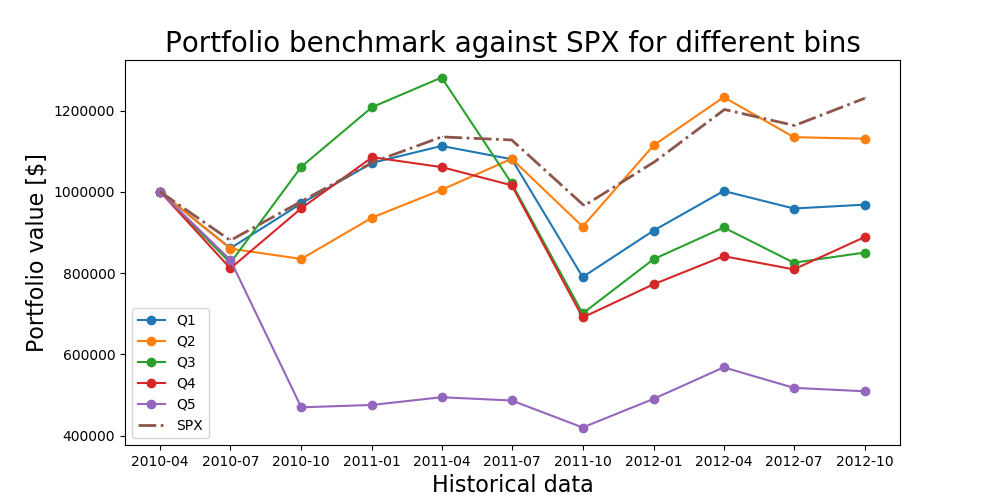

In [34]:
index_name = 'SPX'
display.diff_vs_benchmark(pf_values, index_name, index_data, s)

In [35]:
# Output the data for the pf value
for qtr in s['list_qtr'][s['lag']:]:
    print(qtr, pf_values['diff_jaccard']['Q5'][qtr][0])

(2010, 2) 1000000
(2010, 3) 821528.2196587259
(2010, 4) 913108.9656694984
(2011, 1) 918351.6327533042
(2011, 2) 845666.2808308543
(2011, 3) 835479.899783227
(2011, 4) 666661.8733819026
(2012, 1) 797338.2622709471
(2012, 2) 875221.2090909814
(2012, 3) 821177.3431655745
(2012, 4) 801993.1758749706


In [36]:
# [DEBUG] Show the Apple data for that time period
extracted_cik_scores = cik_scores[data_to_process[0][0]]
# extracted_cik_scores

In [37]:
#ticker = lookup[320193]
ticker = lookup[data_to_process[0][0]]
start_date = qtrs.qtr_to_day(s['time_range'][0], 'first', date_format='datetime')
stop_date = qtrs.qtr_to_day(s['time_range'][1], 'last', date_format='datetime')

#print(s['time_range'], start_date)
#print(s['time_range'], stop_date)
extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}
#print(extracted_data)


# Display the data

## For a given ticker

### Metrics vs stock price

[INFO] Publication dates: 2010-05-03
[INFO] Publication dates: 2010-08-06
[INFO] Publication dates: 2010-11-05
[INFO] Publication dates: 2011-03-01
[INFO] Publication dates: 2011-05-06
[INFO] Publication dates: 2011-08-05
[INFO] Publication dates: 2011-11-04
[INFO] Publication dates: 2012-02-29
[INFO] Publication dates: 2012-05-04
[INFO] Publication dates: 2012-08-03
[INFO] Publication dates: 2012-11-02


<IPython.core.display.Javascript object>


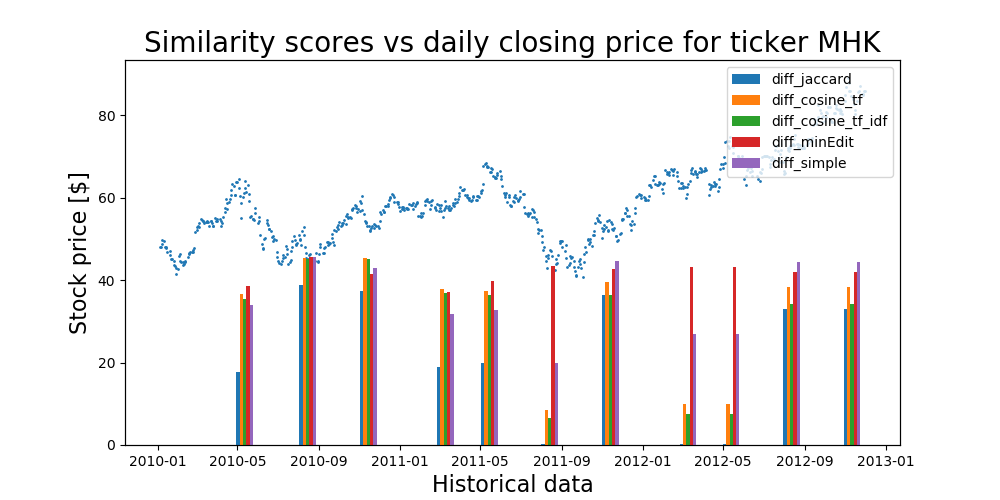

In [38]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')

### Sentiment vs stock price

[INFO] Publication dates: 2010-05-03
[INFO] Publication dates: 2010-08-06
[INFO] Publication dates: 2010-11-05
[INFO] Publication dates: 2011-03-01
[INFO] Publication dates: 2011-05-06
[INFO] Publication dates: 2011-08-05
[INFO] Publication dates: 2011-11-04
[INFO] Publication dates: 2012-02-29
[INFO] Publication dates: 2012-05-04
[INFO] Publication dates: 2012-08-03
[INFO] Publication dates: 2012-11-02


<IPython.core.display.Javascript object>


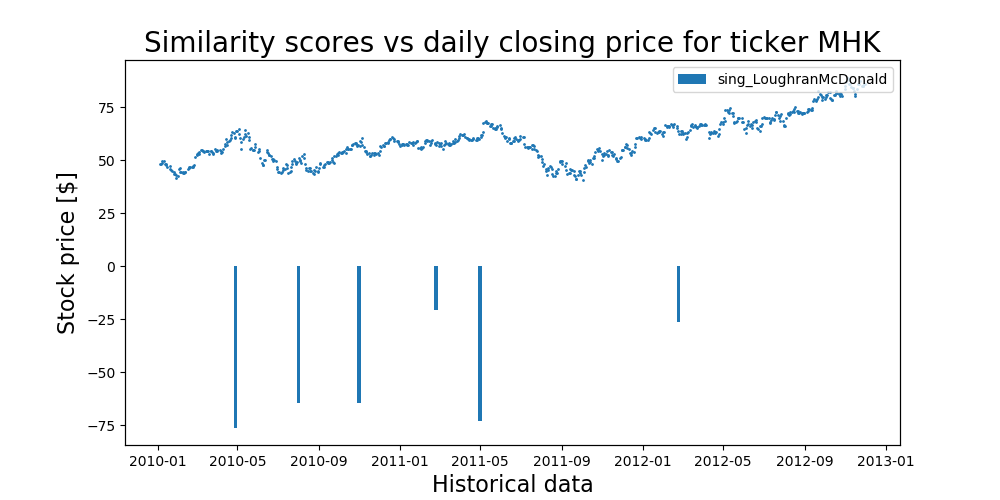

In [39]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='sentiment')